In [1]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



# 数据路径
train_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\dataset 4\Data Files\train'
valid_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\dataset 4\Data Files\valid'
test_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\dataset 4\Data Files\test'

# 解析XML文件，获取标签
def get_label_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = root.findall('object')

    # 如果存在 "thermal_defect"，返回 1，否则返回 0
    for obj in objects:
        if obj.find('name').text == 'thermal_defect':
            return "1"  # 必须是字符串

    return "0"  # 也必须是字符串


def count_defects_in_directory(data_dir):
    with_defect = 0
    without_defect = 0
    
    for xml_file in os.listdir(data_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(data_dir, xml_file)
            label = get_label_from_xml(xml_path)
            
            if label == "1":
                with_defect += 1
            else:
                without_defect += 1
    
    return with_defect, without_defect

# 统计数据集中有缺陷和无缺陷的图像数量
train_with_defect, train_without_defect = count_defects_in_directory(train_dir)
valid_with_defect, valid_without_defect = count_defects_in_directory(valid_dir)
test_with_defect, test_without_defect = count_defects_in_directory(test_dir)


# 处理数据，返回 DataFrame（包含文件路径和标签）
def create_dataframe(data_dir):
    data = []
    
    for xml_file in os.listdir(data_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(data_dir, xml_file)
            img_path = xml_path.replace('.xml', '.jpg')  # 假设图像文件与 XML 同名
            
            if os.path.exists(img_path):  # 确保图像文件存在
                label = get_label_from_xml(xml_path)  # 确保是字符串
                data.append([img_path, label])
    
    return pd.DataFrame(data, columns=['filepath', 'label'])

# 创建数据集 DataFrame
train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)

# 统计数据
print(f"Train set: {len(train_df)} images")
print(f"Valid set: {len(valid_df)} images")
print(f"Test set: {len(test_df)} images")

# 训练数据增强（仅用于训练集）
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 归一化
    rotation_range=30,  # 随机旋转
    width_shift_range=0.2,  # 水平平移
    height_shift_range=0.2,  # 垂直平移
    shear_range=0.2,  # 剪切变换
    zoom_range=0.2,  # 缩放
    horizontal_flip=True  # 随机水平翻转
)

# 验证 & 测试数据（仅归一化，不做增强）
valid_test_datagen = ImageDataGenerator(rescale=1./255)



# 生成训练数据
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(128,128),
    batch_size = 32,
    class_mode="categorical"  
)

# 生成验证数据
valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepath",
    y_col="label",
    target_size=(128,128),
     batch_size = 32,
    class_mode="categorical"
)

# 生成测试数据
test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128,128),
    batch_size = 32,
    class_mode="categorical",
    shuffle=False  # 测试数据不打乱顺序
)

# 输出数据量
print(f"Train generator samples: {train_generator.samples}")
print(f"Valid generator samples: {valid_generator.samples}")
print(f"Test generator samples: {test_generator.samples}")
print(train_df['label'])
# 输出结果
print(f"Train set - defect: {train_with_defect}, no_defect: {train_without_defect}")
print(f"Valid set - defect: {valid_with_defect}, no_defect: {valid_without_defect}")
print(f"Test set - defect: {test_with_defect}, no_defect: {test_without_defect}")


D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train set: 3748 images
Valid set: 1071 images
Test set: 533 images
Found 3748 validated image filenames belonging to 2 classes.
Found 1071 validated image filenames belonging to 2 classes.
Found 533 validated image filenames belonging to 2 classes.
Train generator samples: 3748
Valid generator samples: 1071
Test generator samples: 533
0       1
1       1
2       1
3       1
4       1
       ..
3743    1
3744    1
3745    1
3746    1
3747    1
Name: label, Length: 3748, dtype: object
Train set - defect: 3321, no_defect: 427
Valid set - defect: 942, no_defect: 129
Test set - defect: 470, no_defect: 63


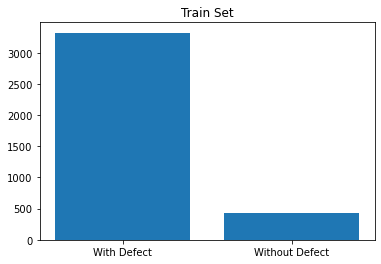

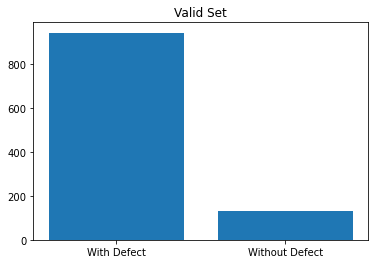

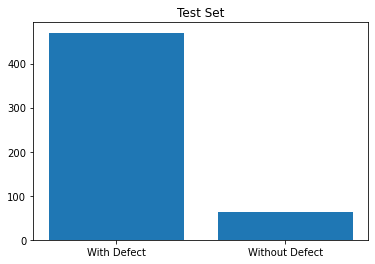

In [2]:
import matplotlib.pyplot as plt

def plot_class_distribution(with_defect, without_defect, title):
    plt.bar(['With Defect', 'Without Defect'], [with_defect, without_defect])
    plt.title(title)
    plt.show()

plot_class_distribution(train_with_defect, train_without_defect, 'Train Set')
plot_class_distribution(valid_with_defect, valid_without_defect, 'Valid Set')
plot_class_distribution(test_with_defect, test_without_defect, 'Test Set')

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def inception_module(x, filters):
    # 1x1卷积分支
    conv1x1 = Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    
    # 3x3卷积分支
    conv3x3 = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    
    # 5x5卷积分支
    conv5x5 = Conv2D(filters, (5,5), padding='same', activation='relu')(x)
    
    # 池化分支
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = Conv2D(filters, (1,1), padding='same', activation='relu')(pool)
    
    # 合并各分支
    merged = concatenate([conv1x1, conv3x3, conv5x5, pool], axis=-1)
    return merged

def attention_block(inputs):
    # 计算注意力权重并加权特征
    attention = Dense(1, activation='tanh')(inputs)    # (batch_size, seq_length, 1)
    attention = Flatten()(attention)                   # (batch_size, seq_length)
    attention = Activation('softmax')(attention)       # (batch_size, seq_length)
    attention = Reshape((inputs.shape[1], 1))(attention)  # (batch_size, seq_length, 1)
    
    # 广播乘法，保留三维输出（不求和）
    context = Multiply()([inputs, attention])          # (batch_size, seq_length, features)
    return context


# 输入层
inputs = Input(shape=(128,128, 3))

# Inception模块
x = inception_module(inputs, 32)
x = MaxPooling2D(2)(x)
x = inception_module(x, 64)
x = MaxPooling2D(2)(x)
x = inception_module(x, 128)
x = GlobalAveragePooling2D()(x)

# 转换为序列数据
x = Reshape((-1, 128))(x)  # 将特征转换为时间步序列

# BiLSTM层
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)
# 注意力机制
x = attention_block(x)
x = GlobalAveragePooling1D()(x)

# 分类层
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x) 

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                              

 dense_1 (Dense)                (None, 64)           8256        ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout_1 (Dropout)            (None, 64)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 2)            130         ['dropout_1[0][0]']              
                                                                                                  
Total params: 1,586,243
Trainable params: 1,586,243
Non-trainable params: 0
__________________________________________________________________________________________________


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             Precision(name='precision'), 
             Recall(name='recall'), 
             'AUC']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
# import warnings
# warnings.filterwarnings("ignore", category=tf.keras.utils.generic_utils.CustomMaskWarning)


# assume epochs and bacth size
epochs = 20
batch_size = 32 

steps_per_epoch = train_generator.samples // batch_size
validation_steps = valid_generator.samples // batch_size

from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1),  # 保存验证集损失最小的模型
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
]


model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # 保存最优模型的路径
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  
    validation_data=valid_generator,
    validation_steps=validation_steps, 
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/20
